In [150]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import torch
from redisai import Client
import redis
import torch.nn.functional as F

In [151]:
#! pip install redis

# 0. Load data and some preliminary cleaning


In [152]:
data = pd.read_csv('loan-applications.csv')

In [153]:
data.head()

,Amount,Broker_Status,Broker_Tier,Client_Risk_Rating,Credit_Score_2,Credit_Score_1,Current_Term_Months,Employment_Status_Borrower_2,Employment_Status,Global_Debt_Ratio,Interest_Rate,Loan_To_Value,Mortgage_Position,Mortgage_Purpose,Occupancy_Type,Property_Type,Self_Employed,Total_Debt_Service_Ratio,Approved
0,428022,Approved,Key Account,4,858,463,31,Pension,Salary,56.2,7.10,55,2,Equity Takeout,Rent To Own,Row,False,98.3,0.0
1,765490,Approved,Key Account,4,601,493,23,Other,Pension,9.6,6.79,41,3,Equity Takeout,Rental,Semi-detached,False,88.5,0.0
2,485838,Deactivated,Key Account,3,732,474,32,Self-employed,Self-employed,72.2,8.35,67,1,Refinance for Debt Consolidation,Owner,Apartment High Rise,True,82.2,1.0
3,939589,Approved,Non Key Account,4,715,777,42,Salary,Contract,25.9,8.28,26,1,Purchase,Rental,Row,False,47.9,0.0
4,965183,Approved,Non Key Account,3,829,880,24,Self-employed,Self-employed,47.7,6.07,45,1,Refinance for Debt Consolidation,Rental,Row,True,66.6,0.0


In [154]:
numeric_features = ['Amount', 'Credit_Score_2','Credit_Score_1','Current_Term_Months','Global_Debt_Ratio','Interest_Rate','Loan_To_Value','Total_Debt_Service_Ratio']
categorical_features = ['Broker_Status','Broker_Tier','Client_Risk_Rating','Employment_Status_Borrower_2','Employment_Status','Mortgage_Position','Mortgage_Purpose','Occupancy_Type','Property_Type','Self_Employed']


for c in numeric_features:
    data[c] = data[c].astype(float)

for c in categorical_features:
    data[c] = data[c].astype('category')
    data[c] = data[c].replace(np.nan, 'Other', regex=True)

# 1. Data Split and Pre-Processing

### Split train and test data

In [155]:
y = data['Approved']
X = data.drop("Approved",axis=1)
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)


## 1.1 Pre-Processing - Turn Numeric Columns into Tensor inputs


First, Let's build a "Scaler" in PyTorch to learn the mean and std for each numerical column



In [156]:
# A simplistic TorchScript implementation of a standard scaler
class TorchStandardScaler:
  def fit(self, x):
    self.mean = x.mean(0, keepdim=True)
    self.std = x.std(0, unbiased=False, keepdim=True)
  def transform(self, x):
    x -= self.mean
    x /= (self.std + 1e-7)
    return x

### Apply the Scaler to Learn Mean & Std Deviation of Every Numeric Column

We will be storing the mean & std Tensors as they will be needed at inference stage!

In [157]:
# Apply the Scaler to the training dataset
numeric_features_tensor = torch.tensor(X_train[numeric_features].values.astype(np.float32))
scaler = TorchStandardScaler()
# Use the Scaler learn the mean and std for each numerical feature in the training set
scaler.fit(numeric_features_tensor)
print(f"mean {scaler.mean}, std {scaler.std}")

mean tensor([[7.9383e+05, 6.5010e+02, 6.4818e+02, 2.9772e+01, 5.0594e+01, 6.9739e+00,
         4.2244e+01, 7.5283e+01]]), std tensor([[4.0325e+05, 1.4462e+02, 1.4338e+02, 1.7812e+01, 2.9122e+01, 1.7522e+00,
         2.2104e+01, 2.2202e+01]])


In [158]:
#RedisAI client
con = Client(host='localhost', port=6379)

# bootstrap the mean and std tensors. 
con.tensorset('xgb-loan-approval-numeric-features-mean', scaler.mean.numpy(), dtype='float')
con.tensorset('xgb-loan-approval-numeric-features-std',  scaler.std.numpy(), dtype='float')

# These will be used to scale all numeric values before scoring loan applications

'OK'

### For each numeric feature, Store the Mean & Std Tensors in Redis

You will need them at inference stage to scale features down to [0-1]!

# Scale (Normalize) Numeric Features

The code below shows how to apply the scaler to transform numeric features into a scaled values

In [159]:
numeric_raw_features_tensor = torch.tensor(X_train[numeric_features].values.astype(np.float32))
scaled_features_tensor = scaler.transform(numeric_raw_features_tensor)

## 1.2 Pre-Processing - Categorical Features
We need to turn string values in every categorical feature into a numeric values <p><p>
The process will be 2-fold:
<li> Let's convert every categorical feature value to a 0-based index value </li>
<li> 1-Hot-Encode this 0-based value </li>


   
For example, for a given feature such as Broker Status, the dictionaries could look like this:
    <li> value_to_code['Broker_Status'] = {'Approved': 0, 'Deactivated': 1, 'Watch List': 2} </li>
    <li> code_to_value['Broker_Status'] =  {0: 'Approved', 1: 'Deactivated', 2: 'Watch List'} </li>
    
These 2 dictionaries could be bootstrappeed into RedisAI as Tensors

In [160]:
categorical_data = data[categorical_features]
categorical_data.head()


,Broker_Status,Broker_Tier,Client_Risk_Rating,Employment_Status_Borrower_2,Employment_Status,Mortgage_Position,Mortgage_Purpose,Occupancy_Type,Property_Type,Self_Employed
0,Approved,Key Account,4,Pension,Salary,2,Equity Takeout,Rent To Own,Row,False
1,Approved,Key Account,4,Other,Pension,3,Equity Takeout,Rental,Semi-detached,False
2,Deactivated,Key Account,3,Self-employed,Self-employed,1,Refinance for Debt Consolidation,Owner,Apartment High Rise,True
3,Approved,Non Key Account,4,Salary,Contract,1,Purchase,Rental,Row,False
4,Approved,Non Key Account,3,Self-employed,Self-employed,1,Refinance for Debt Consolidation,Rental,Row,True


In [161]:
#for every categorical feature, build dictionaries mapping unique string values to numeric codes (and viceversa)
value_to_code_dictionary = {}
code_to_value_dictionary = {}
for category in categorical_features:
    ## list of string values in the category
    cat_keys = categorical_data[category].cat.categories.unique().astype('string')
    ## list of int codes mapped to each value in the category
    cat_codes = categorical_data[category].cat.codes.unique()
    ## build a dictionaries mapping string values -> Code and viceversa
    value_to_code_dictionary[category] = dict(zip(cat_keys, cat_codes.tolist())) #numpy int array 2 python int list
    code_to_value_dictionary[category] = dict(zip(cat_codes,cat_keys))


In [162]:
value_to_code_dictionary

{'Broker_Status': {'Approved': 0, 'Deactivated': 1, 'Watch List': 2},
 'Broker_Tier': {'Key Account': 0, 'Non Key Account': 1},
 'Client_Risk_Rating': {'-1': 5,
  '0': 4,
  '1': 3,
  '2': 6,
  '3': 7,
  '4': 2,
  '5': 8,
  '6': 1,
  '7': 0},
 'Employment_Status_Borrower_2': {'Commissions': 4,
  'Contract': 3,
  'Hourly': 6,
  'Other': 5,
  'Pension': 0,
  'Salary': 1,
  'Self-employed': 2},
 'Employment_Status': {'Commissions': 5,
  'Contract': 4,
  'Hourly': 6,
  'Other': 1,
  'Pension': 0,
  'Salary': 3,
  'Self-employed': 2},
 'Mortgage_Position': {'1': 1, '2': 2, '3': 0},
 'Mortgage_Purpose': {'Equity Takeout': 0,
  'Purchase': 4,
  'Purchase Rent to Own': 1,
  'Refinance': 3,
  'Refinance for Debt Consolidation': 2},
 'Occupancy_Type': {'Owner': 1, 'Rent To Own': 2, 'Rental': 0},
 'Property_Type': {'Apartment High Rise': 2,
  'Apartment Low Rise': 3,
  'Row': 0,
  'Semi-detached': 1,
  'Single': 4},
 'Self_Employed': {'False': 0, 'True': 1}}

In [163]:
#Turn raw features data into Float Tensors
def pre_process(numerical_features_df,categorical_features_df,numerical_scaler,categorical_value_to_code_dictionaries,categorical_features):
    #Generate Tensor for Numeric Features
    numeric_raw_features_tensor = torch.tensor(numerical_features_df.values.astype(np.float32))
    scaled_features_tensor = scaler.transform(numeric_raw_features_tensor)
    
    #Generate Tensor for Categorical Features
    
    #1.Turn values into 0-based index (integers)
    mapped_categorical_raw_data = []
    for category in categorical_features:
        v2c_dict = categorical_value_to_code_dictionaries[category]
        mapped_categorical_raw_data.append(categorical_features_df[category].astype('string').map(v2c_dict))
    
    mapped_raw_df = pd.DataFrame(np.column_stack(mapped_categorical_raw_data),columns=categorical_features)

    #2.1-Hot-Encode these 0-based indexes into 1-hot-encoded Tensors
    categorical_1h_tensors = []
    for category in categorical_features:
        v2c_dict= value_to_code_dictionary[category]
        cat_tensor= torch.tensor(mapped_raw_df[category].values.astype(np.int64))
        cat_1h_tensor = F.one_hot(cat_tensor.to(torch.int64),num_classes=len(v2c_dict.keys()))
        categorical_1h_tensors.append(cat_1h_tensor)
    
    one_hot_tensors = torch.hstack(categorical_1h_tensors)
    
    featurized_data = torch.hstack((scaled_features_tensor,one_hot_tensors))
    return featurized_data


In [164]:
X_train_tensor = pre_process(X_train[numeric_features],X_train[categorical_features],scaler,value_to_code_dictionary,categorical_features)

In [165]:
X_train_tensor.shape

torch.Size([4049, 54])

In [166]:
#turn tensor into numpy array for XGB Pipeline
X_train_data = X_train_tensor.numpy().astype('float64')


In [167]:
# Train XGB model
from sklearn.pipeline import Pipeline

xgb_model = Pipeline(steps=[('xgb', XGBClassifier(n_estimators=200,min_child_weight=5,max_depth=4,learning_rate=0.1,objective='binary:logistic',
               eval_metric='logloss', use_label_encoder=False))])

xgb_model.fit(X_train_data,y_train)  

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

# Model Performance on Test Data

In [168]:
X_test_tensor = pre_process(X_test[numeric_features],X_test[categorical_features],scaler,value_to_code_dictionary,categorical_features)
X_test_data = X_test_tensor.numpy().astype('float64')
y_pred = xgb_model.predict(X_test_data)
y_true = y_test.to_numpy().astype(int)

from sklearn.metrics import roc_auc_score
y_pred = xgb_model.predict_proba(X_test_data)[:,1]
print ('Roc Auc on Test data:', roc_auc_score(y_true,y_pred))


Roc Auc on Test data: 0.8348595104627277


# 2. Convert Model to ONNX

## Register the converter for XGBClassifier 
From here https://onnx.ai/sklearn-onnx/auto_tutorial/plot_gexternal_xgboost.html

In [169]:
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes, calculate_linear_regressor_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster

update_registered_converter(
    XGBClassifier, 'XGBoostXGBClassifier',
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={'nocl': [True, False], 'zipmap': [True, False]})

## Time to Convert

http://onnx.ai/sklearn-onnx/pipeline.html

The input into the XGB model is a FloatTensorType[None,54]


In [170]:
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType,StringTensorType

#A single input - A tensor of 54 columns
input_types = [('inputs',FloatTensorType([None, 54]))]

#It would be ideal to the have 2 inputs as below....however, the conversion to onnx fails (complaining on multiple inputs!)
#ipt3=[('input', FloatTensorType([None, 8])),('input_2',Int64TensorType([None,46]))]


#Convert Model to ONNX
#See this http://onnx.ai/sklearn-onnx/api_summary.html
model_onnx = convert_sklearn(xgb_model,initial_types=input_types,name='pipeline_xgboost',target_opset=12)


# And save it to a local file
with open("pipeline_xgboost_2.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

(-0.5, 1945.5, 1796.5, -0.5)

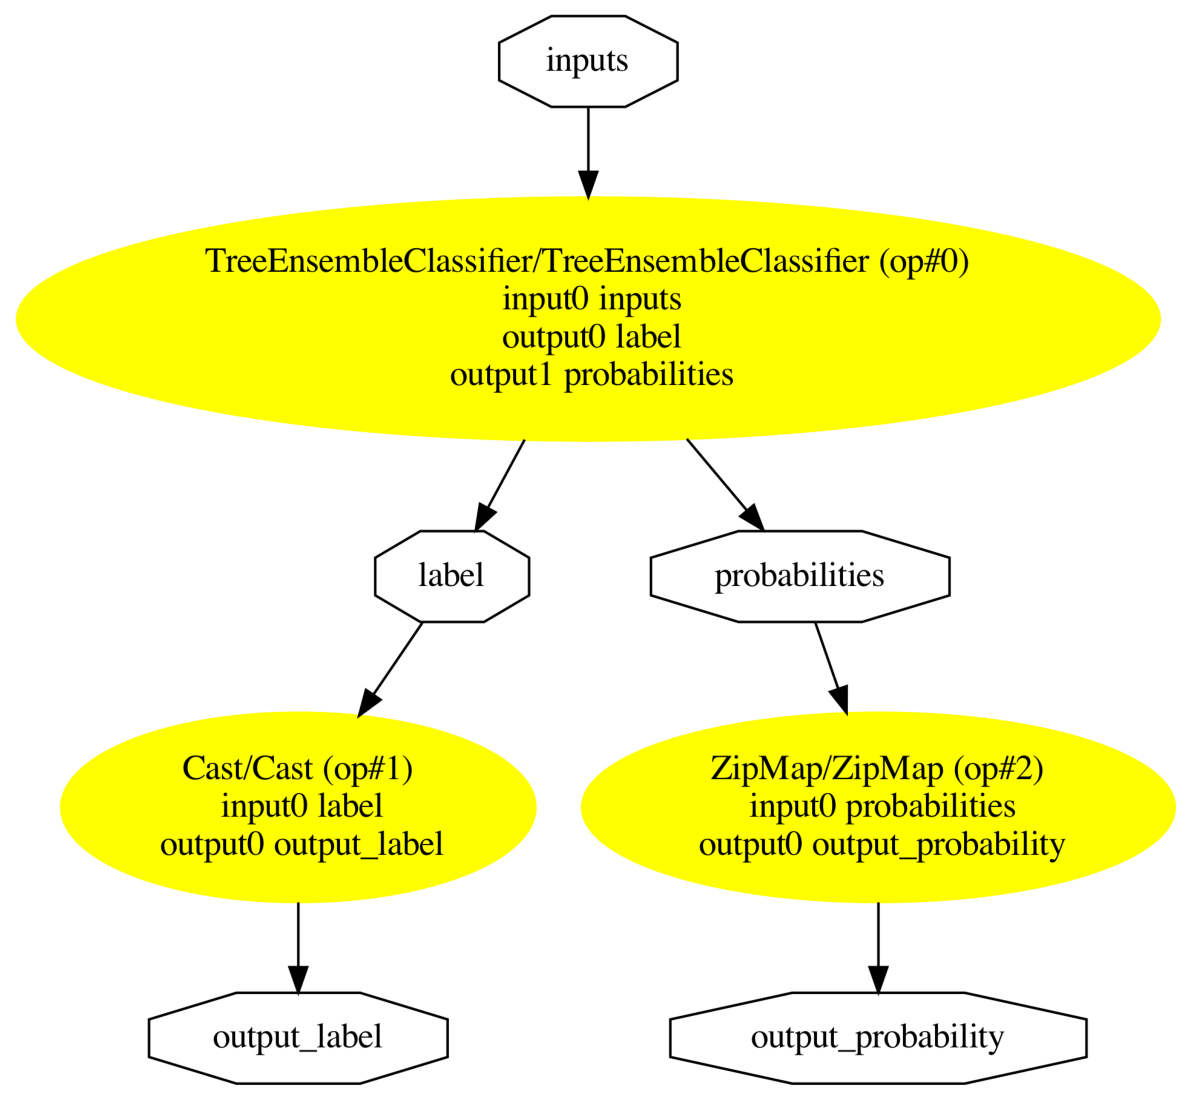

In [171]:
import os
import matplotlib.pyplot as plt
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

pydot_graph = GetPydotGraph(model_onnx.graph, name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))
pydot_graph.write_dot("graph.dot")

os.system('dot -O -Gdpi=300 -Tpng graph.dot')

image = plt.imread("graph.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')


# 3 Compare the Predictions 
XGB model vs ONNX Model

In [172]:
X_test.head(6)

,Amount,Broker_Status,Broker_Tier,Client_Risk_Rating,Credit_Score_2,Credit_Score_1,Current_Term_Months,Employment_Status_Borrower_2,Employment_Status,Global_Debt_Ratio,Interest_Rate,Loan_To_Value,Mortgage_Position,Mortgage_Purpose,Occupancy_Type,Property_Type,Self_Employed,Total_Debt_Service_Ratio
854,139417.0,Approved,Non Key Account,3,894.0,450.0,53.0,Salary,Salary,16.5,8.08,77.0,2,Purchase,Rent To Own,Apartment Low Rise,False,89.2
2560,938870.0,Watch List,Key Account,2,612.0,620.0,58.0,Contract,Salary,69.4,8.20,35.0,3,Equity Takeout,Rent To Own,Single,False,99.1
2212,1038910.0,Approved,Key Account,4,522.0,797.0,29.0,Salary,Hourly,59.6,6.52,41.0,2,Purchase,Rent To Own,Apartment Low Rise,False,79.5
2347,226057.0,Approved,Non Key Account,3,585.0,553.0,33.0,Commissions,Other,70.1,9.58,68.0,1,Refinance,Owner,Apartment Low Rise,False,80.3
1529,586268.0,Approved,Key Account,3,524.0,480.0,51.0,Pension,Pension,53.7,4.98,77.0,2,Purchase Rent to Own,Owner,Row,False,83.6
799,423647.0,Approved,Key Account,4,874.0,429.0,31.0,Self-employed,Other,29.7,9.07,57.0,2,Refinance for Debt Consolidation,Owner,Single,False,87.3


# Predicting With the ONNX Model in ONNXRuntime
Check the ONNX model actually works prior to loading into RedisAI

In [173]:
#Pre-process the test data
X_test_tensor = pre_process(X_test[numeric_features],X_test[categorical_features],scaler,value_to_code_dictionary,categorical_features)
X_test_data = X_test_tensor.numpy().astype('float32')


In [174]:
import onnxruntime as rt
sess = rt.InferenceSession("pipeline_xgboost_2.onnx")
for i in sess.get_inputs():
    print (i.name)
for o  in sess.get_outputs():
    print (o.name)
pred_onx = sess.run(None, {'inputs':X_test_data[:10]})
print("predict", pred_onx[0][:10])
print("predict_proba", pred_onx[1][:10])
#print (pred_onx[1])

inputs
output_label
output_probability
predict [0 0 0 0 0 1 0 0 0 0]
predict_proba [{0: 0.9954002499580383, 1: 0.00459975004196167}, {0: 0.7656233906745911, 1: 0.23437660932540894}, {0: 0.9432613253593445, 1: 0.05673867464065552}, {0: 0.7229185700416565, 1: 0.2770814299583435}, {0: 0.5416952967643738, 1: 0.4583047032356262}, {0: 0.12650728225708008, 1: 0.8734927177429199}, {0: 0.6643624305725098, 1: 0.33563756942749023}, {0: 0.8668301105499268, 1: 0.13316988945007324}, {0: 0.7923541069030762, 1: 0.20764589309692383}, {0: 0.7190420627593994, 1: 0.2809579372406006}]


## Predictions with the XGB Model
For the first 10 loan applications in the test set

In [175]:
print("predict", xgb_model.predict(X_test_data[:10]))
print("predict_proba", xgb_model.predict_proba(X_test_data[:10]))

predict [0 0 0 0 0 1 0 0 0 0]
predict_proba [[0.9954002  0.00459983]
 [0.7656234  0.23437661]
 [0.9432614  0.05673861]
 [0.7229185  0.2770815 ]
 [0.54169524 0.45830473]
 [0.12650728 0.8734927 ]
 [0.66436243 0.33563754]
 [0.8668301  0.13316986]
 [0.7923541  0.20764586]
 [0.71904206 0.28095794]]


# Versions used in this example

In [176]:
import sklearn
import onnx
import onnxruntime as rt
import skl2onnx
import numpy

print("numpy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)
print("onnx: ", onnx.__version__)
print("onnxruntime: ", rt.__version__)
print("skl2onnx: ", skl2onnx.__version__)

numpy: 1.20.3
scikit-learn: 0.24.2
onnx:  1.9.0
onnxruntime:  1.8.0
skl2onnx:  1.8.0


# Load a few loan applications into a Redis as hashes

In [177]:
import redis
r = redis.Redis('localhost', port=6379)

def load_loan_applications (r, test):
    print('loading loan-applications to be scored as Redis hashes with the following keys')
    for index, row in test.iterrows():
        loan_application_data = {
            'Amount' :row['Amount'],
            'Credit_Score_2':row['Credit_Score_2'],
            'Credit_Score_1':row['Credit_Score_1'],
            'Current_Term_Months':row['Current_Term_Months'],
            'Global_Debt_Ratio':row['Global_Debt_Ratio'],
            'Interest_Rate':row['Interest_Rate'],
            'Loan_To_Value':row['Loan_To_Value'],
            'Total_Debt_Service_Ratio':row['Total_Debt_Service_Ratio'],
            'Broker_Status':row['Broker_Status'],
            'Broker_Tier':row['Broker_Tier'],
            'Client_Risk_Rating':row['Client_Risk_Rating'],
            'Employment_Status_Borrower_2':row['Employment_Status_Borrower_2'],
            'Employment_Status':row['Employment_Status'],
            'Mortgage_Position':row['Mortgage_Position'],
            'Mortgage_Purpose':row['Mortgage_Purpose'],
            'Occupancy_Type':row['Occupancy_Type'],
            'Property_Type':row['Property_Type'],
            'Self_Employed':str(row['Self_Employed'])

        }
        print('loan-application-' + str(index+1))
        r.hset('loan-application-'+str(index+1),mapping=loan_application_data)

load_loan_applications(r,X_test.head(10))
    

loading loan-applications to be scored as Redis hashes with the following keys
loan-application-855
loan-application-2561
loan-application-2213
loan-application-2348
loan-application-1530
loan-application-800
loan-application-600
loan-application-1247
loan-application-1424
loan-application-1400
